In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.utils import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

# Suppress extra logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# 1️⃣ Dataset

data_dir = "/kaggle/input/realwaste/realwaste-main/RealWaste"  # ✅ make sure this path exists
img_size = (128, 128)
batch_size = 32

dataset = image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=123
)




2025-10-26 02:05:48.611747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761444348.775053      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761444348.820927      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 4752 files belonging to 9 classes.


I0000 00:00:1761444364.526400      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761444364.527068      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [2]:
# 2️⃣ Split dataset (70/15/15)

dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)

train_ds = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_ds = remaining.take(val_size)
test_ds = remaining.skip(val_size)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)




In [3]:
# 3️⃣ Improved CNN Model

model = keras.Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(len(dataset.class_names), activation='softmax')
])

model.summary()




/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,519,241 (24.87 MB)

 Trainable params: 6,518,793 (24.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [4]:
# 4️⃣ Compile

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# 5️⃣ Callbacks

#early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)



In [5]:

# 6️⃣ Train (100 epochs)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[ reduce_lr]
)




Epoch 1/100


I0000 00:00:1761444379.441684     105 service.cc:148] XLA service 0x7c4af8009020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761444379.442611     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761444379.442629     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761444379.857755     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/104 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.1765 - loss: 9.8126

I0000 00:00:1761444384.090410     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


104/104 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - accuracy: 0.2893 - loss: 6.5177 - val_accuracy: 0.0895 - val_loss: 13.8183 - learning_rate: 0.0010
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3480 - loss: 1.9097 - val_accuracy: 0.3523 - val_loss: 2.0546 - learning_rate: 0.0010
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4087 - loss: 1.7349 - val_accuracy: 0.4702 - val_loss: 1.5696 - learning_rate: 0.0010
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4233 - loss: 1.6317 - val_accuracy: 0.4432 - val_loss: 1.6752 - learning_rate: 0.0010
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4565 - loss: 1.5718 - val_accuracy: 0.5014 - val_loss: 1.4581 - learning_rate: 0.0010
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4705 - loss: 1.4546 - val_accuracy: 0.2670 - val_loss: 2.7229 - learning_rate: 0.0010
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5039 - loss: 1.324

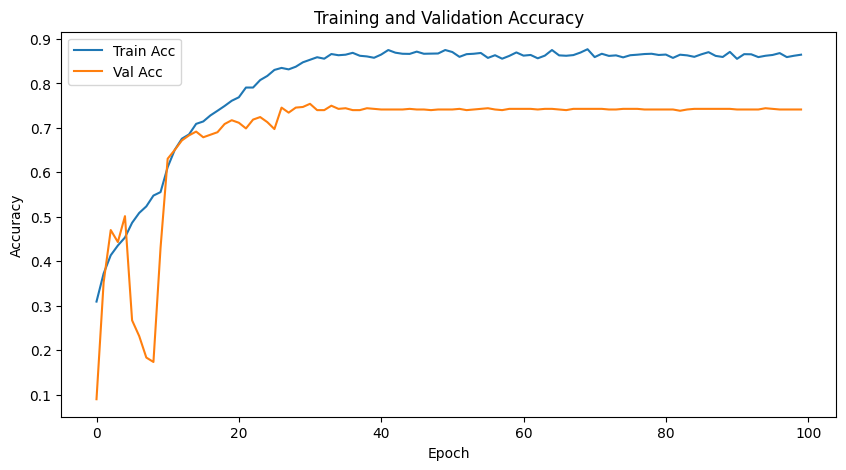

In [7]:
# 7️⃣ Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




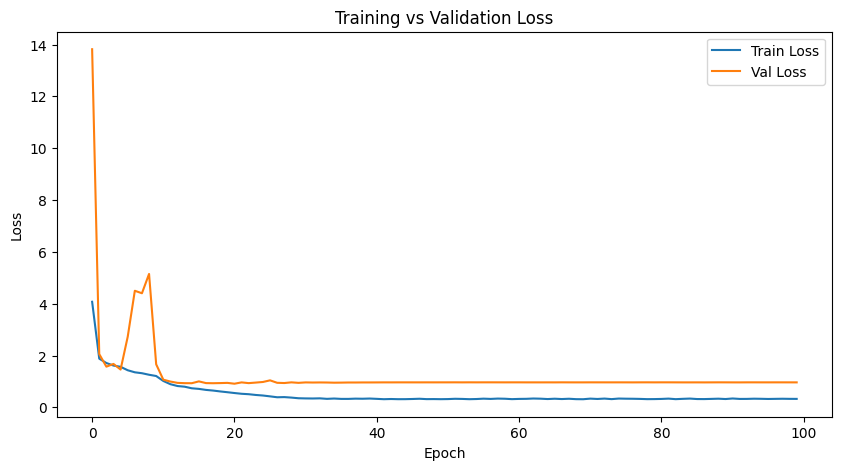

In [9]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# 8️⃣ Evaluate

test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

print(classification_report(y_true, y_pred, target_names=dataset.class_names))


23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.6816 - loss: 1.2048
✅ Test Accuracy: 0.6736
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
                     precision    recall  f1-score   support

          Cardboard       0.73      0.61      0.66        71
      Food Organics       0.75      0.73      0.74        60
              Glass       0.78      0.73      0.75        52
              Metal       0.66      0.63      0.65       127
Miscellaneous Trash       0.54      0.53      0.53        74
              Paper       0.63      0.66      0.64        70
            Plastic       0.62      0.72      0.67       143
      Textile Trash       0.57      0.47      0.52        49
         Vegetation       0.85      0.93      0.89        74

           accuracy                           0.67       720
          macro avg       0.68      0.67      0.67       720
       weighted avg       0.67      0.67      0.67       720

